<a href="https://colab.research.google.com/github/zzzle96/PyTorch/blob/master/MM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jhhuang96/ConvLSTM-PyTorch

Cloning into 'ConvLSTM-PyTorch'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 108 (delta 52), reused 59 (delta 18), pack-reused 0
Receiving objects: 100% (108/108), 9.50 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
import sys
sys.path.append('/content/ConvLSTM-PyTorch')
print(sys.path)



['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/ConvLSTM-PyTorch']


In [3]:
pip install tensorboardX

     |████████████████████████████████| 317kB 2.8MB/s 


In [42]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from encoder import Encoder
from decoder import Decoder
from model import ED
from net_params import convlstm_encoder_params, convlstm_decoder_params, convgru_encoder_params, convgru_decoder_params
from data.mm import MovingMNIST
import torch
from torch import nn
from torch.optim import lr_scheduler
import torch.optim as optim
import sys
from earlystopping import EarlyStopping
from tqdm import tqdm
import numpy as np
from tensorboardX import SummaryWriter
import argparse
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


random_seed = 1996
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.device_count() > 1:
    torch.cuda.manual_seed_all(random_seed)
else:
    torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

save_dir = './save_model/' + TIMESTAMP

trainFolder = MovingMNIST(is_train=True,
                          root='/content/ConvLSTM-PyTorch/data',
                          n_frames_input=10,
                          n_frames_output=10,
                          num_objects=[3])
validFolder = MovingMNIST(is_train=False,
                          root='/content/ConvLSTM-PyTorch/data',
                          n_frames_input=10,
                          n_frames_output=10,
                          num_objects=[3])
trainLoader = torch.utils.data.DataLoader(trainFolder,
                                          batch_size=1,
                                          shuffle=False)
validLoader = torch.utils.data.DataLoader(validFolder,
                                          batch_size=1,
                                          shuffle=False)



In [68]:
def imshow (img):
    img = img/ 2+0.5
    np_img = img.numpy()
    plt.imshow(np_img)
    #plt.imshow(np.transpose(np_img, (1,0,2,3,4)))
    print(np_img.shape)

TypeError: ignored

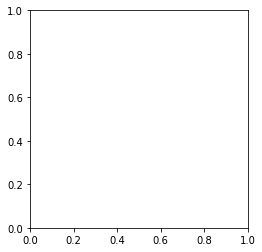

In [74]:
import torchvision
import torchvision.transforms as transforms
dataiter = iter(trainLoader)
batch,images1 , images2, images3, labels = dataiter.next()
#images1 = dataiter.next()
images1 = images1[0]
imshow(torchvision.utils.make_grid(images1))

In [30]:
print(images.shape)

AttributeError: ignored

In [4]:
|#!/usr/bin/env python
# -*- encoding: utf-8 -*-
'''
@File    :   main.py
@Time    :   2020/03/09
@Author  :   jhhuang96
@Mail    :   hjh096@126.com
@Version :   1.0
@Description:   
'''

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from encoder import Encoder
from decoder import Decoder
from model import ED
from net_params import convlstm_encoder_params, convlstm_decoder_params, convgru_encoder_params, convgru_decoder_params
from data.mm import MovingMNIST
import torch
from torch import nn
from torch.optim import lr_scheduler
import torch.optim as optim
import sys
from earlystopping import EarlyStopping
from tqdm import tqdm
import numpy as np
from tensorboardX import SummaryWriter
import argparse

TIMESTAMP = "2020-03-09T00-00-00"                         
parser = argparse.ArgumentParser()
parser.add_argument('-clstm',
                    '--convlstm',
                    help='use convlstm as base cell',
                    action='store_true')
parser.add_argument('-cgru',
                    '--convgru',
                    help='use convgru as base cell',
                    action='store_true')
parser.add_argument('--batch_size',
                    default=4,
                    type=int,
                    help='mini-batch size')
parser.add_argument('-lr', default=1e-4, type=float, help='G learning rate')
parser.add_argument('-frames_input',
                    default=10,
                    type=int,
                    help='sum of input frames')
parser.add_argument('-frames_output',
                    default=10,
                    type=int,
                    help='sum of predict frames')
parser.add_argument('-epochs', default=500, type=int, help='sum of epochs')
args = parser.parse_args()

random_seed = 1996
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.device_count() > 1:
    torch.cuda.manual_seed_all(random_seed)
else:
    torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

save_dir = './save_model/' + TIMESTAMP

trainFolder = MovingMNIST(is_train=True,
                          root='data/',
                          n_frames_input=args.frames_input,
                          n_frames_output=args.frames_output,
                          num_objects=[3])
validFolder = MovingMNIST(is_train=False,
                          root='data/',
                          n_frames_input=args.frames_input,
                          n_frames_output=args.frames_output,
                          num_objects=[3])
trainLoader = torch.utils.data.DataLoader(trainFolder,
                                          batch_size=args.batch_size,
                                          shuffle=False)
validLoader = torch.utils.data.DataLoader(validFolder,
                                          batch_size=args.batch_size,
                                          shuffle=False)

if args.convlstm:
    encoder_params = convlstm_encoder_params
    decoder_params = convlstm_decoder_params
if args.convgru:
    encoder_params = convgru_encoder_params
    decoder_params = convgru_decoder_params
else:
    encoder_params = convgru_encoder_params
    decoder_params = convgru_decoder_params


def train():
    '''
    main function to run the training
    '''
    encoder = Encoder(encoder_params[0], encoder_params[1]).cuda()
    decoder = Decoder(decoder_params[0], decoder_params[1]).cuda()
    net = ED(encoder, decoder)
    run_dir = './runs/' + TIMESTAMP
    if not os.path.isdir(run_dir):
        os.makedirs(run_dir)
    tb = SummaryWriter(run_dir)
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=20, verbose=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)
    net.to(device)

    if os.path.exists(os.path.join(save_dir, 'checkpoint.pth.tar')):
        # load existing model
        print('==> loading existing model')
        model_info = torch.load(os.path.join(save_dir, 'checkpoin.pth.tar'))
        net.load_state_dict(model_info['state_dict'])
        optimizer = torch.optim.Adam(net.parameters())
        optimizer.load_state_dict(model_info['optimizer'])
        cur_epoch = model_info['epoch'] + 1
    else:
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        cur_epoch = 0
    lossfunction = nn.MSELoss().cuda()
    optimizer = optim.Adam(net.parameters(), lr=args.lr)
    pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      factor=0.5,
                                                      patience=4,
                                                      verbose=True)

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []
    # mini_val_loss = np.inf
    for epoch in range(cur_epoch, args.epochs + 1):
        ###################
        # train the model #
        ###################
        t = tqdm(trainLoader, leave=False, total=len(trainLoader))
        for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
            inputs = inputVar.to(device)  # B,S,C,H,W
            label = targetVar.to(device)  # B,S,C,H,W
            optimizer.zero_grad()
            net.train()
            pred = net(inputs)  # B,S,C,H,W
            loss = lossfunction(pred, label)
            loss_aver = loss.item() / args.batch_size
            train_losses.append(loss_aver)
            loss.backward()
            torch.nn.utils.clip_grad_value_(net.parameters(), clip_value=10.0)
            optimizer.step()
            t.set_postfix({
                'trainloss': '{:.6f}'.format(loss_aver),
                'epoch': '{:02d}'.format(epoch)
            })
        tb.add_scalar('TrainLoss', loss_aver, epoch)
        ######################
        # validate the model #
        ######################
        with torch.no_grad():
            net.eval()
            t = tqdm(validLoader, leave=False, total=len(validLoader))
            for i, (idx, targetVar, inputVar, _, _) in enumerate(t):
                if i == 3000:
                    break
                inputs = inputVar.to(device)
                label = targetVar.to(device)
                pred = net(inputs)
                loss = lossfunction(pred, label)
                loss_aver = loss.item() / args.batch_size
                # record validation loss
                valid_losses.append(loss_aver)
                #print ("validloss: {:.6f},  epoch : {:02d}".format(loss_aver,epoch),end = '\r', flush=True)
                t.set_postfix({
                    'validloss': '{:.6f}'.format(loss_aver),
                    'epoch': '{:02d}'.format(epoch)
                })

        tb.add_scalar('ValidLoss', loss_aver, epoch)
        torch.cuda.empty_cache()
        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(args.epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{args.epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.6f} ' +
                     f'valid_loss: {valid_loss:.6f}')

        print(print_msg)
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        pla_lr_scheduler.step(valid_loss)  # lr_scheduler
        model_dict = {
            'epoch': epoch,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        early_stopping(valid_loss.item(), model_dict, epoch, save_dir)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    with open("avg_train_losses.txt", 'wt') as f:
        for i in avg_train_losses:
            print(i, file=f)

    with open("avg_valid_losses.txt", 'wt') as f:
        for i in avg_valid_losses:
            print(i, file=f)


if __name__ == "__main__":
    train()


usage: ipykernel_launcher.py [-h] [-clstm] [-cgru] [--batch_size BATCH_SIZE]
                             [-lr LR] [-frames_input FRAMES_INPUT]
                             [-frames_output FRAMES_OUTPUT] [-epochs EPOCHS]
ipykernel_launcher.py: error: ambiguous option: -f could match -frames_input, -frames_output


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
